In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
import joblib
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
figures_dir = Path("artifacts/figures")
figures_dir.mkdir(parents=True, exist_ok=True)


In [2]:
def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.show()

def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    plt.show()

1.EDA

In [3]:
df = pd.read_csv('S06-hw-dataset-02.csv')
df.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

In [5]:
df.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000
mean,9000.500000,-0.418555,0.614251,0.004559,0.059000,0.405086,0.012123,-0.283473,-0.266880,0.255107,...,-0.139825,0.108568,0.007238,0.000904,-0.716862,-0.274520,0.344991,1.517339,2.576221e+01,0.262611
std,5196.296758,2.178005,3.926778,1.000134,5.713672,2.497581,0.987226,2.193891,2.081431,2.225776,...,2.148834,2.234315,0.997861,1.002115,3.913704,2.482890,4.927315,10.630850,5.423748e+01,0.440065
min,1.000000,-10.014698,-15.510323,-4.031762,-23.663256,-12.289308,-3.741536,-9.591425,-8.293319,-13.655742,...,-8.171469,-9.214171,-3.937091,-3.963063,-19.389908,-10.031559,-20.768452,-107.788145,1.895059e-07,0.000000
25%,4500.750000,-1.866134,-2.048192,-0.673127,-3.544964,-1.153000,-0.653090,-1.743214,-1.688121,-1.177480,...,-1.589638,-1.369266,-0.663023,-0.684164,-3.286842,-1.897893,-2.752685,-2.018750,1.226029e+00,0.000000
50%,9000.500000,-0.465100,0.600291,0.003581,0.072826,0.485625,0.018765,-0.251263,-0.302463,0.350739,...,-0.204785,0.158715,0.001912,-0.003157,-0.618472,-0.339901,0.573153,0.318011,6.581865e+00,0.000000
75%,13500.250000,0.966393,3.229850,0.671390,3.689490,2.075739,0.689304,1.195481,1.109589,1.764113,...,1.254595,1.600671,0.677296,0.676558,1.948803,1.314163,3.649794,4.212111,2.576847e+01,1.000000
max,18000.000000,9.589975,15.417329,3.817025,26.815691,10.665184,3.528280,7.794627,8.892834,8.699629,...,9.290667,8.794320,4.341030,3.781380,14.065595,10.639974,20.226291,94.891804,1.103449e+03,1.000000


In [6]:
df.dtypes

id           int64
f01        float64
f02        float64
f03        float64
f04        float64
f05        float64
f06        float64
f07        float64
f08        float64
f09        float64
f10        float64
f11        float64
f12        float64
f13        float64
f14        float64
f15        float64
f16        float64
f17        float64
f18        float64
f19        float64
f20        float64
f21        float64
f22        float64
f23        float64
f24        float64
f25        float64
f26        float64
f27        float64
f28        float64
f29        float64
f30        float64
f31        float64
f32        float64
f33        float64
f34        float64
f35        float64
x_int_1    float64
x_int_2    float64
target       int64
dtype: object

In [7]:
df.isna().sum()

id         0
f01        0
f02        0
f03        0
f04        0
f05        0
f06        0
f07        0
f08        0
f09        0
f10        0
f11        0
f12        0
f13        0
f14        0
f15        0
f16        0
f17        0
f18        0
f19        0
f20        0
f21        0
f22        0
f23        0
f24        0
f25        0
f26        0
f27        0
f28        0
f29        0
f30        0
f31        0
f32        0
f33        0
f34        0
f35        0
x_int_1    0
x_int_2    0
target     0
dtype: int64

In [8]:
df['target'].value_counts()

target
0    13273
1     4727
Name: count, dtype: int64

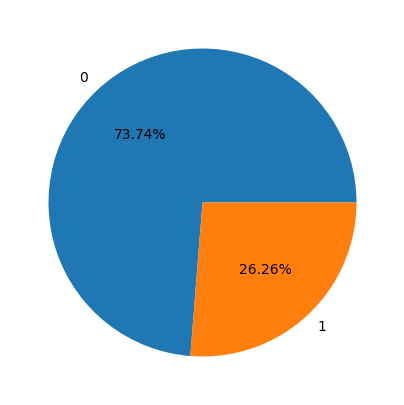

In [9]:
plt.figure(figsize=(5,5))
plt.pie(df['target'].value_counts(), labels=[0,1], autopct='%1.2f%%')
plt.savefig(figures_dir)
plt.show()

In [10]:
corr = df.corr()
print(corr['target'])

id        -0.000632
f01       -0.089671
f02       -0.150825
f03        0.002079
f04       -0.043078
f05        0.087707
f06        0.005071
f07        0.003977
f08        0.007492
f09        0.005358
f10       -0.005402
f11        0.027296
f12       -0.094174
f13        0.083725
f14        0.108904
f15       -0.010231
f16       -0.332261
f17       -0.001927
f18       -0.104297
f19        0.168282
f20       -0.010899
f21       -0.012954
f22       -0.012297
f23        0.025414
f24       -0.002479
f25        0.003582
f26        0.010841
f27        0.003443
f28       -0.003571
f29        0.093073
f30       -0.099362
f31       -0.001224
f32       -0.002248
f33        0.125053
f34        0.007948
f35        0.103889
x_int_1   -0.037229
x_int_2   -0.113397
target     1.000000
Name: target, dtype: float64


In [11]:
df.shape

(18000, 39)

2. Models

In [12]:
X = df.drop(['id', 'target'], axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y) #Стратификация позволяет сохранять баланс классов

2.1 Baselines

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
best_models = {}
search_summaries = {}  

#Dummy
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
results.append(evaluate_on_test(dummy, X_test, y_test, 'Dummy("stratified")'))
best_models['Dummy("stratified)'] = dummy

#LogisticRegression
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=7000, random_state=RANDOM_STATE))
])

lr_grid = {
    "lr__C": [0.1, 1.0, 10.0],
    "lr__penalty": ["l2"],
    "lr__solver": ["lbfgs"],
}

lr_search = GridSearchCV(
    lr, lr_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_
best_models["LogReg(scaled)"] = best_lr

search_summaries["LogReg(scaled)"] = {
    "best_params": lr_search.best_params_,
    "best_cv_roc_auc": float(lr_search.best_score_),
}

results.append(evaluate_on_test(best_lr, X_test, y_test, "LogReg(scaled)"))

search_summaries["LogReg(scaled)"]


D:\ai__course\ai_course\homeworks\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


{'best_params': {'lr__C': 10.0, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'},
 'best_cv_roc_auc': 0.8034441518518427}

2.2 DecisionTree, RandomForest, GradientBoosting

In [14]:
def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True,
        verbose=2
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search

In [15]:
dt = DecisionTreeClassifier()
dt_grid = {
    'max_depth': [6, 8, 10, None],
    'min_samples_leaf': [5, 10, 20, 30],
    'ccp_alpha': [0.0, 0.005, 0.01, 0.1]
}
dt_search = run_search('DecisionTree', dt, dt_grid)
search_summaries['DecisionTree']

Fitting 5 folds for each of 64 candidates, totalling 320 fits


{'best_params': {'ccp_alpha': 0.0, 'max_depth': 10, 'min_samples_leaf': 30},
 'best_cv_roc_auc': 0.8359264710760994}

In [16]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    oob_score=False
)
rf_grid = {
    'max_depth': [None, 3, 7],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

rf_search = run_search('RandomForest', rf, rf_grid)
search_summaries['RandomForest']

Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'best_params': {'max_depth': None,
  'max_features': 'log2',
  'min_samples_leaf': 1},
 'best_cv_roc_auc': 0.9279582542943938}

In [17]:
gb = GradientBoostingClassifier(
    loss='log_loss',
    random_state=RANDOM_STATE
)
gb_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, None],
    "max_leaf_nodes": [15, 28, 65],
}

gb_search = run_search("GradientBoosting", gb, gb_grid)
search_summaries["GradientBoosting"]

Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'best_params': {'learning_rate': 0.1,
  'max_depth': None,
  'max_leaf_nodes': 65},
 'best_cv_roc_auc': 0.9314534298656298}

2.3 stacking

In [18]:
estimators = [
    ('lr', best_models['LogReg(scaled)']),
    ('rf', best_models['RandomForest']),
    ('gb', best_models['GradientBoosting'])
]
stack_cl = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=7000, random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1,
    passthrough=False
)
stack_cl.fit(X_train, y_train)
best_models["Stacking"] = stack_cl
results.append(evaluate_on_test(stack_cl, X_test, y_test, "Stacking"))

3. results

In [19]:
res_df = pd.DataFrame(results)
df_sorted = res_df.copy()
df_sorted["roc_auc_sort"] = df_sorted["roc_auc"].fillna(-1.0)
df_sorted = df_sorted.sort_values(["roc_auc_sort", "accuracy"], ascending=False).drop(columns=["roc_auc_sort"])

df_sorted

,accuracy,f1,roc_auc,model
5,0.917222,0.832396,0.934427,Stacking
4,0.909167,0.809552,0.932590,GradientBoosting
3,0.890000,0.750943,0.928694,RandomForest
2,0.833889,0.648649,0.845916,DecisionTree
1,0.811944,0.560675,0.797692,LogReg(scaled)
0,0.615278,0.266031,0.502672,"Dummy(""stratified"")"


In [24]:
best_row = df_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

best_label, best_row.to_dict()

('Stacking',
 {'accuracy': 0.9172222222222223,
  'f1': 0.8323959505061868,
  'roc_auc': 0.9344274056138463,
  'model': 'Stacking'})

In [20]:
def for_metrics_test(df_metr: pd.DataFrame):
    return {
        row['model']: {
            'accuracy': row['accuracy'],
            'f1': row['f1'],
            'roc_auc': row['roc_auc']
        }
        for _, row in df_metr.iterrows()
    }
    

metr_t = for_metrics_test(df_sorted)
print(type(metr_t))
print(metr_t)

<class 'dict'>
{'Stacking': {'accuracy': 0.9172222222222223, 'f1': 0.8323959505061868, 'roc_auc': 0.9344274056138463}, 'GradientBoosting': {'accuracy': 0.9091666666666667, 'f1': 0.8095515433896331, 'roc_auc': 0.9325904004623403}, 'RandomForest': {'accuracy': 0.89, 'f1': 0.7509433962264151, 'roc_auc': 0.9286937892964258}, 'DecisionTree': {'accuracy': 0.8338888888888889, 'f1': 0.6486486486486487, 'roc_auc': 0.8459157624129375}, 'LogReg(scaled)': {'accuracy': 0.8119444444444445, 'f1': 0.5606748864373783, 'roc_auc': 0.7976922846979344}, 'Dummy("stratified")': {'accuracy': 0.6152777777777778, 'f1': 0.2660307366189719, 'roc_auc': 0.5026724060622366}}


4. Сохранение результатов

In [21]:
metrics_path = ARTIFACTS_DIR / "metrics_test.json"
search_path = ARTIFACTS_DIR / "search_summaries.json"

save_json(metr_t, metrics_path)
save_json(search_summaries, search_path)

print("Saved:", metrics_path)
print("Saved:", search_path)

Saved: artifacts\metrics_test.json
Saved: artifacts\search_summaries.json


In [22]:
best_model_name = next(iter(metr_t))
best_model_metrics = metr_t[best_model_name]

print("Лучшая модель:", best_model_name)
print("Метрики:", best_model_metrics)

Лучшая модель: Stacking
Метрики: {'accuracy': 0.9172222222222223, 'f1': 0.8323959505061868, 'roc_auc': 0.9344274056138463}


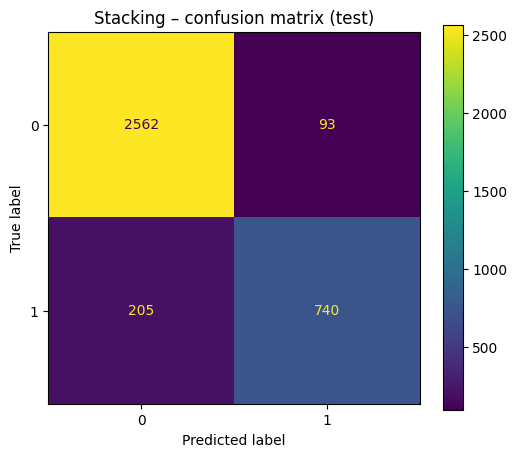

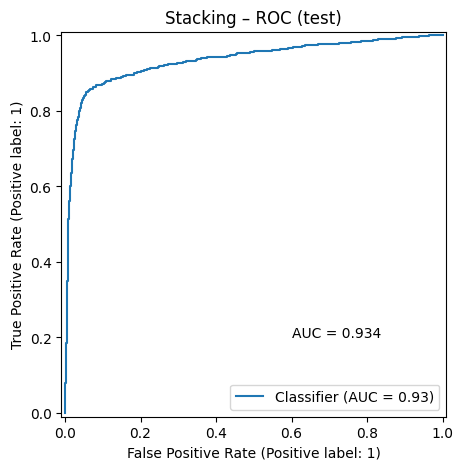

In [25]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.set_title(f"{best_label} – confusion matrix (test)")
fig.savefig(figures_dir / "stacking_confusion_matrix_test.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)
fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax)
ax.set_title(f"{best_label} – ROC (test)")
auc = roc_auc_score(y_test, y_proba)
ax.text(0.6, 0.2, f"AUC = {auc:.3f}")
fig.savefig(figures_dir / "ROC_test.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)


In [26]:
model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_model_name,
    "test_metrics": best_model_metrics,
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")

print("Saved:", model_path)
print("Saved:", ARTIFACTS_DIR / "best_model_meta.json")

Saved: artifacts\best_model.joblib
Saved: artifacts\best_model_meta.json


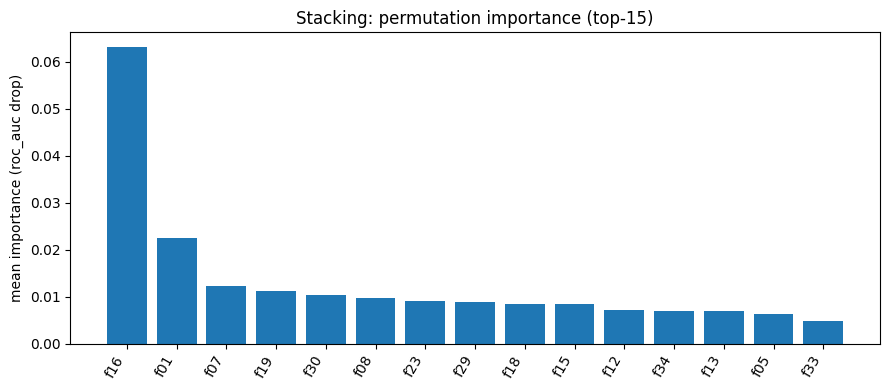

In [27]:
scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "accuracy"

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]
feature_names = X_test.columns
plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.savefig(figures_dir /'stacking(permutation importance).png')
plt.show()
     
